In [4]:
import sys
import os
sys.path.append(os.path.abspath("../src/"))
import extract.data_loading as data_loading
import extract.compute_predictions as compute_predictions
import extract.compute_shap as compute_shap
import extract.compute_ism as compute_ism
import model.util as model_util
import model.profile_models as profile_models
import model.binary_models as binary_models
import plot.viz_sequence as viz_sequence
import pyBigWig
import torch
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
import json
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/att-priors/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


|<bar/>| 0/? [00:00<?, ?it/s]

### Define paths for the model and data of interest

In [2]:
model_type = "binary"

In [3]:
# Shared paths/constants
reference_fasta = "/users/amtseng/genomes/hg38.fasta"
chrom_sizes = "/users/amtseng/genomes/hg38.canon.chrom.sizes"
data_base_path = "/users/amtseng/att_priors/data/processed/"
model_base_path = "/users/amtseng/att_priors/models/trained_models/%s/" % model_type
chrom_set = ["chr1"]
input_length = 1346 if model_type == "profile" else 1000
profile_length = 1000

In [5]:
# GC content track
gc_content_track = "/users/amtseng/att_priors/data/raw/gc_content/hg38_1000bp_gc_content.bw"

In [4]:
# SPI1
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/SPI1/SPI1_training_paths.json" % model_type)
num_tasks = 4
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "SPI1/17/model_ckpt_epoch_2.pt")
prior_model_path = os.path.join(model_base_path, "SPI1_prior/1/model_ckpt_epoch_4.pt")

In [24]:
# GATA2
files_spec_path = os.path.join(data_base_path, "ENCODE_TFChIP/%s/config/GATA2/GATA2_training_paths.json" % model_type)
num_tasks = 3
num_strands = 2
controls = "matched"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithMatchedControls
else:
    model_class = binary_models.BinaryPredictor
noprior_model_path = os.path.join(model_base_path, "GATA2/4/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "GATA2_prior/3/model_ckpt_epoch_4.pt")

In [6]:
# K562
files_spec_path = os.path.join(data_base_path, "ENCODE_DNase/%s/config/K562/K562_training_paths.json" % model_type)
num_tasks = 1
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
task_ind = None
footprint_path = "/users/amtseng/att_priors/data/processed/DNase_footprints/K562.bed.gz"
noprior_model_path = os.path.join(model_base_path, "K562_keep1/29/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "K562_prior_keep1/16/model_ckpt_epoch_1.pt")

In [27]:
# BPNet
reference_fasta = "/users/amtseng/genomes/mm10.fasta"
chrom_sizes = "/users/amtseng/genomes/mm10.canon.chrom.sizes"
files_spec_path = os.path.join(data_base_path, "BPNet_ChIPseq/%s/config/BPNet_training_paths.json" % model_type)
num_tasks = 1
controls = "shared"
if model_type == "profile":
    model_class = profile_models.ProfilePredictorWithSharedControls
else:
    model_class = binary_models.BinaryPredictor
task_ind = 0  # Only Nanog for now
footprint_path = "/users/amtseng/att_priors/data/raw/BPNet_ChIPnexus/BPNet_NANOG_footprints.bed.gz"
pos_bigwig = "/users/amtseng/att_priors/data/raw/BPNet_ChIPnexus/BPNet_NANOG_pos.bw"
neg_bigwig = "/users/amtseng/att_priors/data/raw/BPNet_ChIPnexus/BPNet_NANOG_neg.bw"
noprior_model_path = os.path.join(model_base_path, "BPNet/17/model_ckpt_epoch_1.pt")
prior_model_path = os.path.join(model_base_path, "BPNet_prior/2/model_ckpt_epoch_10.pt")

In [7]:
torch.set_grad_enabled(True)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
def restore_model(model_path):
    model = model_util.restore_model(model_class, model_path)
    model.eval()
    model = model.to(device)
    return model

In [28]:
# Import the model without priors
noprior_model = restore_model(noprior_model_path)

In [29]:
# Import the model with priors
prior_model = restore_model(prior_model_path)

### Data preparation
Create an input data loader, that maps coordinates or bin indices to data needed for the model. We also create a loader for the GC content

In [30]:
if model_type == "profile":
    input_func = data_loading.get_profile_input_func(
        files_spec_path, input_length, profile_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_profile_coords(
        files_spec_path, chrom_set=chrom_set
    )
else:
    input_func = data_loading.get_binary_input_func(
        files_spec_path, input_length, reference_fasta
    )
    pos_examples = data_loading.get_positive_binary_bins(
        files_spec_path, chrom_set=chrom_set
    )

In [12]:
def fetch_gc_content(chrom, pos):
    """
    Fetches GC content centered at this position.
    """
    with pyBigWig.open(gc_content_track, "r") as f:
        return np.nan_to_num(f.values(chrom, pos, pos + 1))[0]

### Compute importances

In [31]:
# Pick a sample of 1000 random coordinates/bins
num_samples = 1000
sample = pos_examples[np.random.choice(len(pos_examples), size=num_samples, replace=False)]

In [16]:
def compute_gradients(model, sample):
    """
    Given an array of N coordinates or bins, computes the input gradients
    for the model, returning an N x I x 4 array of gradient values and an
    N x I x 4 array of one-hot encoded sequence.
    """
    if model_type == "profile":
        results = compute_predictions.get_profile_model_predictions(                                              
            model, sample, num_tasks, input_func, controls=controls,                        
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    else:
        results = compute_predictions.get_binary_model_predictions(                                              
            model, sample, input_func,                      
            return_losses=False, return_gradients=True, show_progress=True                                         
        )
    return results["input_grads"], results["input_seqs"]

In [17]:
def compute_shap_scores(model, sample, batch_size=128):
    """
    Given an array of N coordinates or bins, computes the SHAP scores
    for the model, returning an N x I x 4 array of SHAP scores and an
    N x I x 4 array of one-hot encoded sequence.
    """
    num_samples = len(sample)
    num_batches = int(np.ceil(num_samples / batch_size))
    
    all_shap_scores = np.empty((num_samples, input_length, 4))
    all_one_hot_seqs = np.empty((num_samples, input_length, 4))
        
    if model_type == "profile":
        shap_explainer = compute_shap.create_profile_explainer(
            model, input_length, profile_length, num_tasks, num_strands, controls
        )
    else:
        shap_explainer = compute_shap.create_binary_explainer(
            model, input_length, num_tasks
        )

    for i in tqdm.notebook.trange(num_batches):
        batch_slice = slice(i * batch_size, (i + 1) * batch_size)
        batch = sample[batch_slice]

        if model_type == "profile":
            input_seqs, profiles = input_func(sample)
            shap_scores = shap_explainer(
                input_seqs, cont_profs=profiles[:, num_tasks:], hide_shap_output=True
            )
        else:
            input_seqs, _, _ = input_func(sample)
            shap_scores = shap_explainer(
                input_seqs, hide_shap_output=True
            )

        all_shap_scores[batch_slice] = shap_scores
        all_one_hot_seqs[batch_slice] = input_seqs
    return all_shap_scores, all_one_hot_seqs

In [32]:
# Compute the importance scores and 1-hot seqs
noprior_scores, _ = compute_gradients(noprior_model, sample)
prior_scores, one_hot_seqs = compute_gradients(prior_model, sample)

100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


### Compare importance tracks to GC content

In [33]:
noprior_frac_gc = np.sum(np.abs(noprior_scores[:, :, 1:3]), axis=(1, 2)) / np.sum(np.abs(noprior_scores), axis=(1, 2))
prior_frac_gc = np.sum(np.abs(prior_scores[:, :, 1:3]), axis=(1, 2)) / np.sum(np.abs(prior_scores), axis=(1, 2))

Average fraction without priors: 0.518166
Average fraction with priors: 0.499964
Test of difference of means: t = 33.761199, p = 0.000000


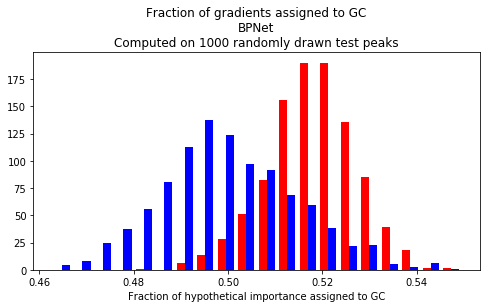

In [35]:
bin_num = 20
plt.figure(figsize=(8, 4))
plt.hist(
    [noprior_frac_gc, prior_frac_gc],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"]
)
plt.title(
    "Fraction of gradients assigned to GC\n" +
    "BPNet" +
    "\nComputed on 1000 randomly drawn test peaks"
)
plt.xlabel("Fraction of hypothetical importance assigned to GC")

print("Average fraction without priors: %f" % np.mean(noprior_frac_gc))
print("Average fraction with priors: %f" % np.mean(prior_frac_gc))
t, p = scipy.stats.ttest_ind(noprior_frac_gc, prior_frac_gc)
print("Test of difference of means: t = %f, p = %f" % (t, p / 2))